<a href="https://colab.research.google.com/github/GoldenCorgi/Clustering/blob/main/ys_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q umap-learn[plot] 
!pip install -q opentsne

In [2]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import umap
import umap.plot
from matplotlib import pyplot as plt
from openTSNE import TSNE
from scipy import ndimage
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster, datasets, manifold, mixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import fetch_openml, load_iris
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

np.random.seed(0)

In [3]:
# Datasets

def get_Digits():
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    X, y = datasets.load_digits(return_X_y=True)
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y

def get_MNIST():
    mnist = fetch_openml('mnist_784')
    return mnist.data, mnist.target


# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), [0]*n_samples

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


# Normal Digits (~1.7k samples)
X, y = get_Digits()

# MNIST
# X, y = get_MNIST()

In [4]:
## Labels in string form instead of int
y_labels= [0]*len(y)
for i in range(len(y)):
    y_labels[i] = str(y[i])

In [5]:
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)

Computing embedding


In [6]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [7]:
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {}),
    ((X_red,y), {'n_clusters': 10}),
    ]


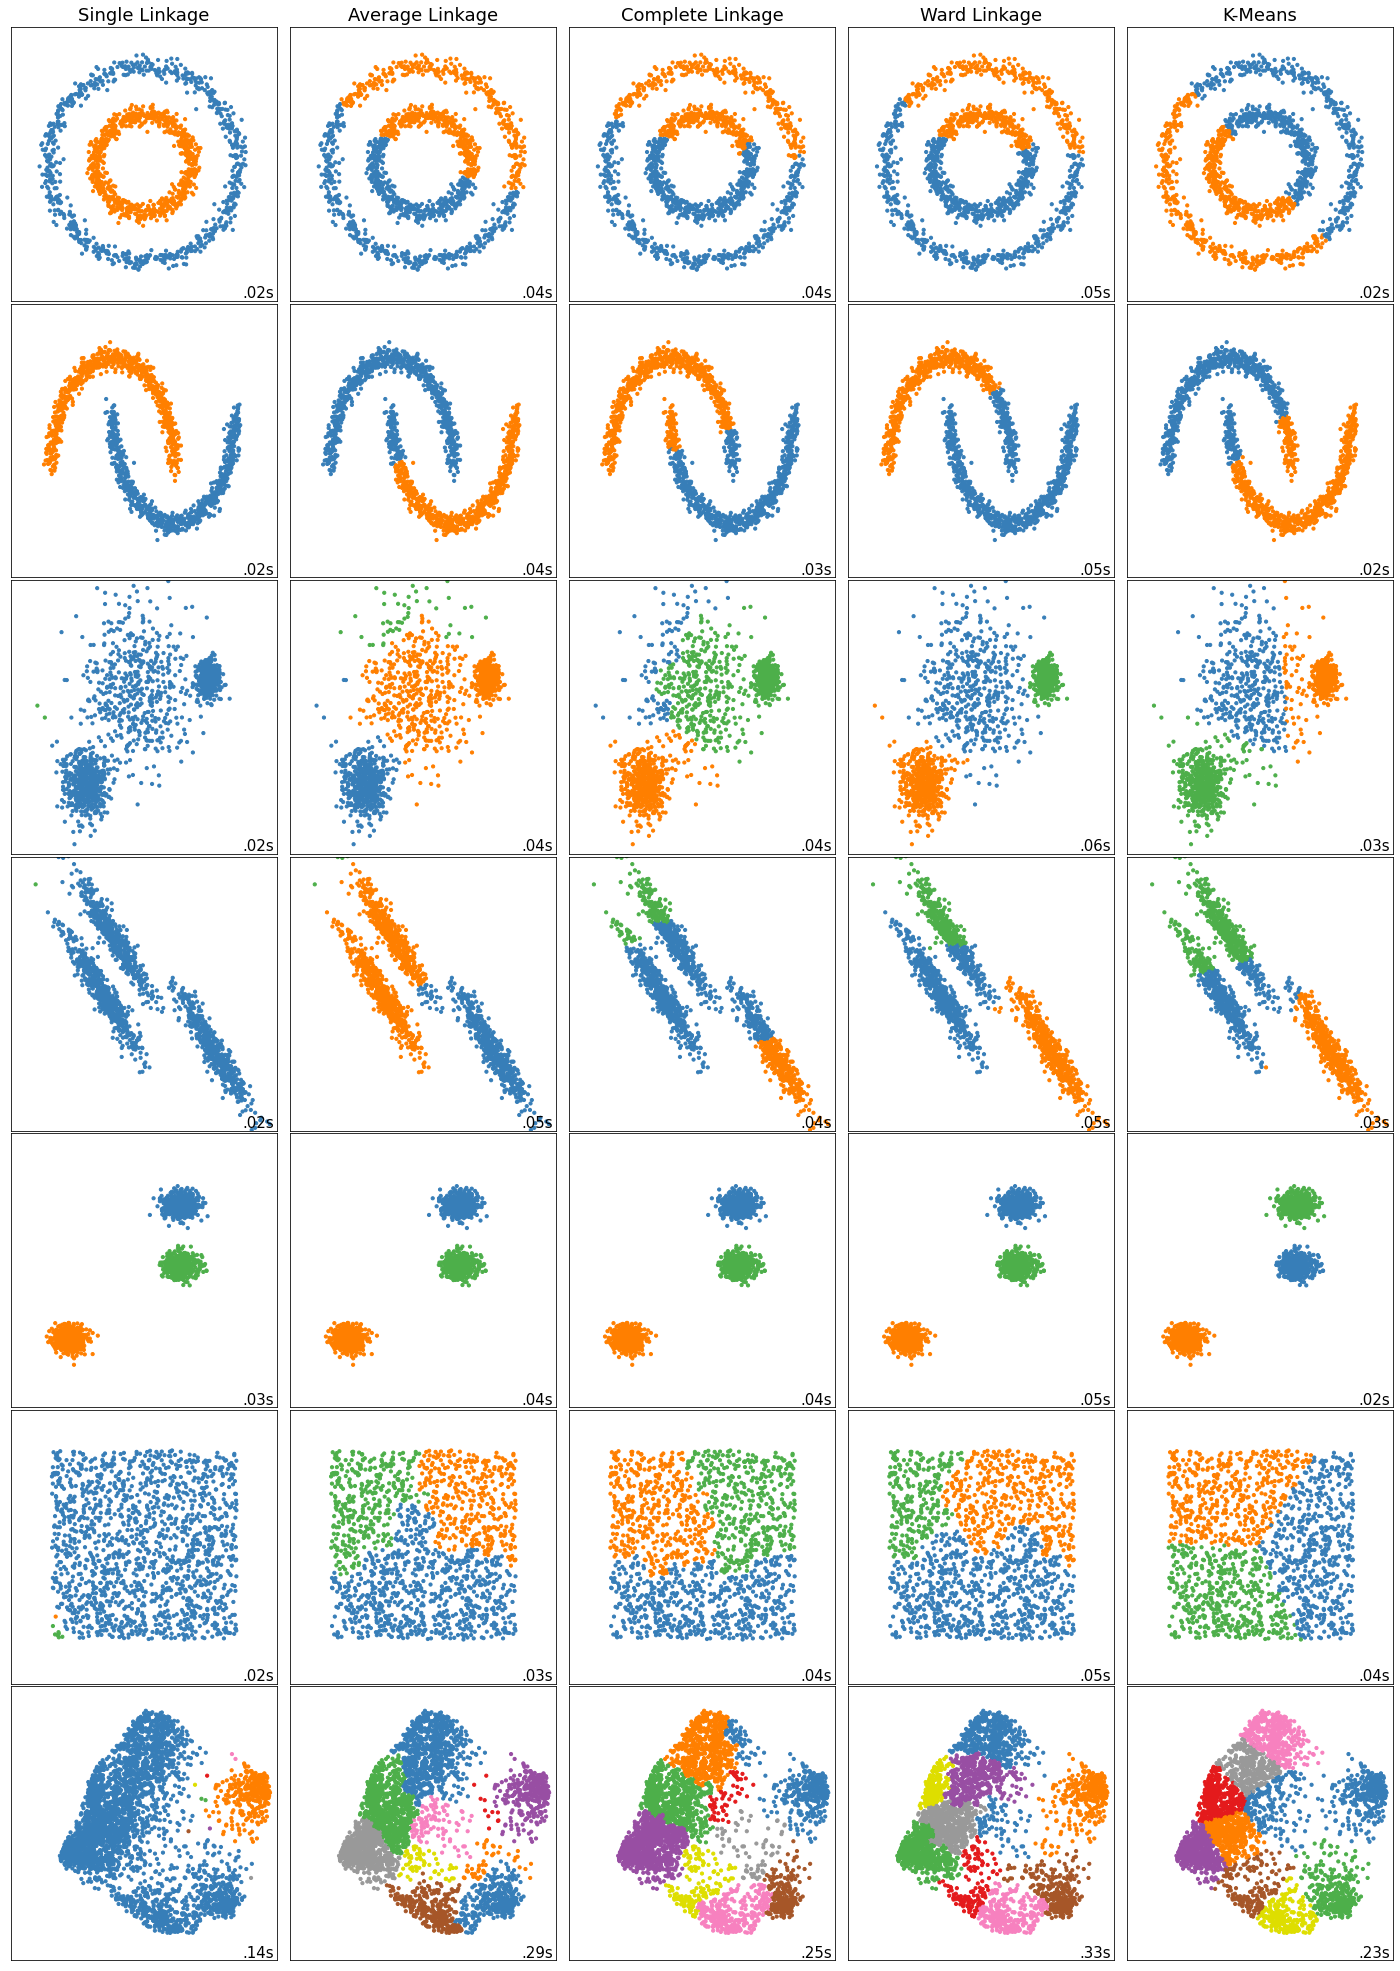

In [8]:
# Set up cluster parameters



plt.figure(figsize=(20, 4*len(datasets)))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}


for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')
    k_means = cluster.KMeans(n_clusters=params['n_clusters'], random_state=0)

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
        ('K-Means', k_means),

    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


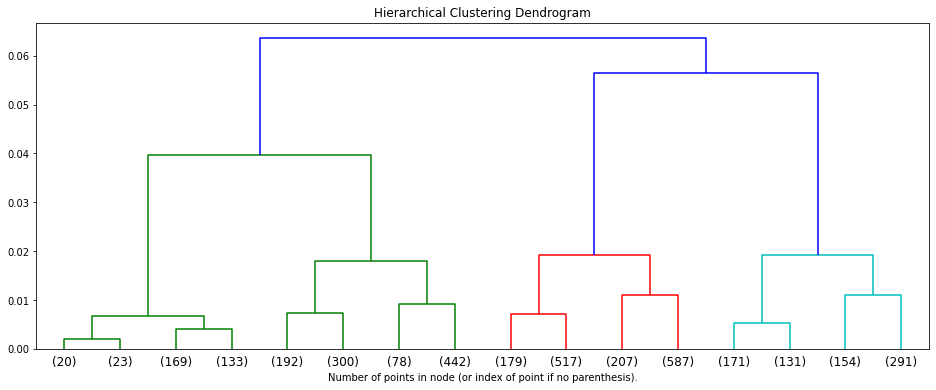

In [9]:
plt.figure(figsize=(16, 6))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_red)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [10]:

save_data = []

def savingdata(a,b,c):
    save_data.append([a,b,c.tolist().copy()])

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
    callbacks=[savingdata],
    n_iter=100,
    early_exaggeration_iter=50,
    callbacks_every_iters=10
)

In [11]:
%time embedding_train = tsne.fit(X)

--------------------------------------------------------------------------------
TSNE(callbacks=[<function savingdata at 0x7f1068366f80>],
     callbacks_every_iters=10, dof=1, early_exaggeration=12,
     early_exaggeration_iter=50, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, max_step_norm=5,
     metric='euclidean', metric_params=None, min_num_intervals=50,
     n_components=2, n_interpolation_points=3, n_iter=100, n_jobs=8,
     negative_gradient_method='auto', neighbors='auto', perplexity=30,
     random_state=42, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2.75 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.24 seconds
===> Calculating PCA-based initialization...
   --> Time elapse

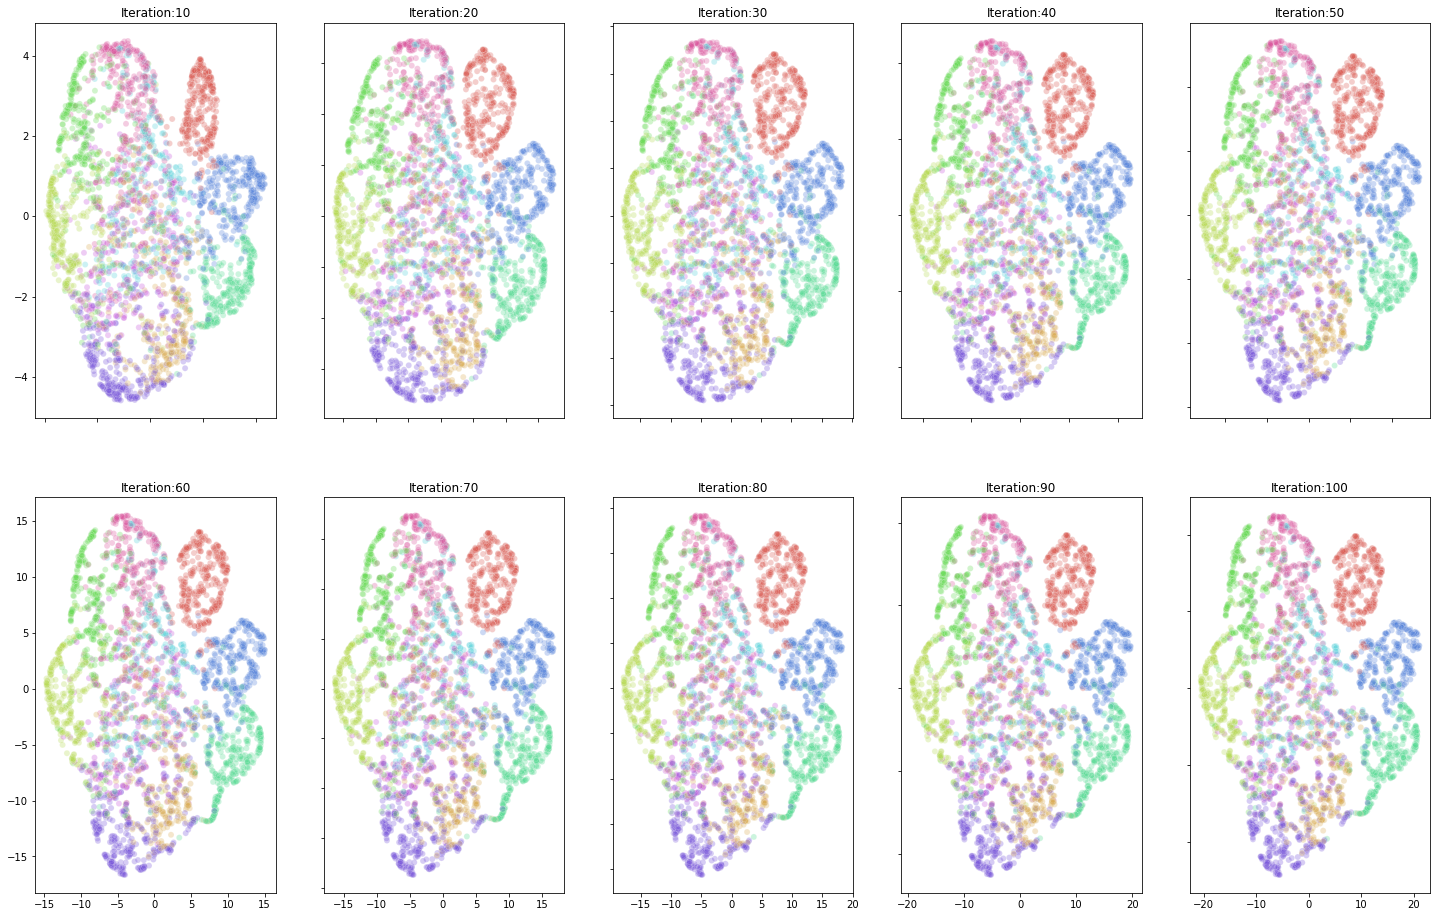

In [12]:
def plot_data(dataset,title="Iteration"):
    ROW_NUM = 5
    COL_NUM = len(dataset)//ROW_NUM + (len(dataset) % ROW_NUM > 0)
    fig, axs = plt.subplots(COL_NUM, ROW_NUM,figsize=(25,8*COL_NUM))


    for idx, data in enumerate(dataset):
        if COL_NUM > 1:
            axes = axs[idx//ROW_NUM,idx%ROW_NUM]
        else:
            axes = axs[idx]
        sns.scatterplot(
        x=[x[0] for x in data[2]], y=[x[1] for x in data[2]],
        hue=y,
        palette=sns.color_palette("hls", 10),
        legend=False,
        alpha=0.3,ax = axes
        )
        axes.set_title(title+":"+str(data[0]))

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


plot_data(save_data[5:])

In [13]:
perplexity_data = []

for perplexity in tqdm([30,50,70,90,100]):
    tsne = TSNE(
        perplexity=perplexity,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        n_iter=100,
        early_exaggeration_iter=50,

    )
    embedding_train = tsne.fit(X)
    perplexity_data.append([perplexity,"",embedding_train.tolist().copy()])

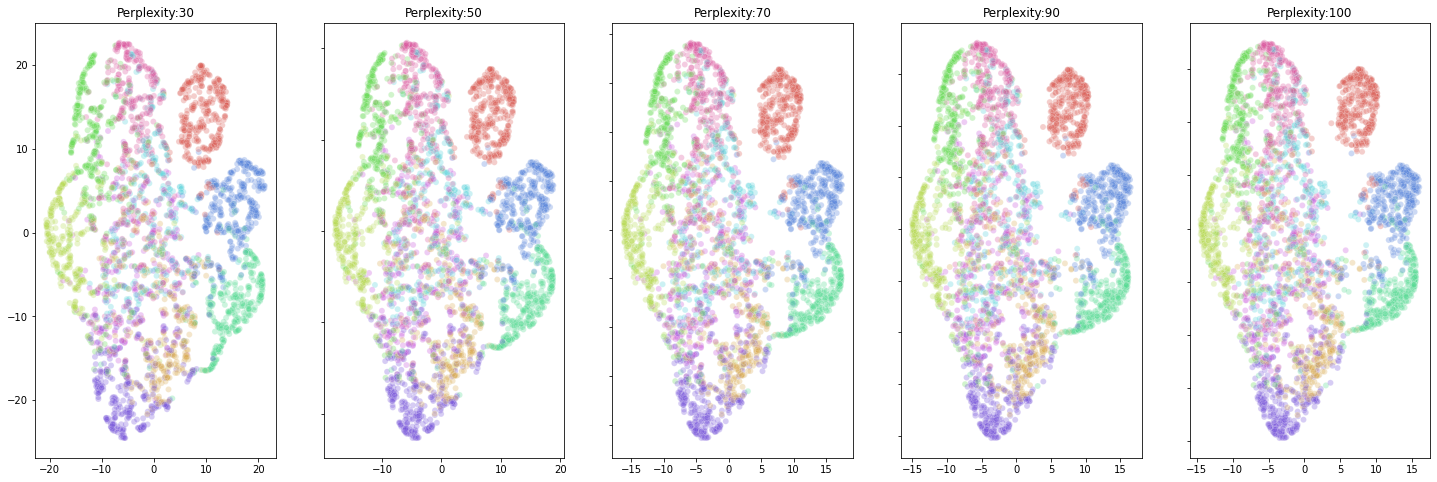

In [14]:
plot_data(perplexity_data,"Perplexity")

In [15]:
mapper = umap.UMAP(verbose=True).fit(X)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Fri Jul 16 14:47:30 2021 Finding Nearest Neighbors
Fri Jul 16 14:47:34 2021 Finished Nearest Neighbor Search
Fri Jul 16 14:47:37 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Jul 16 14:47:46 2021 Finished embedding


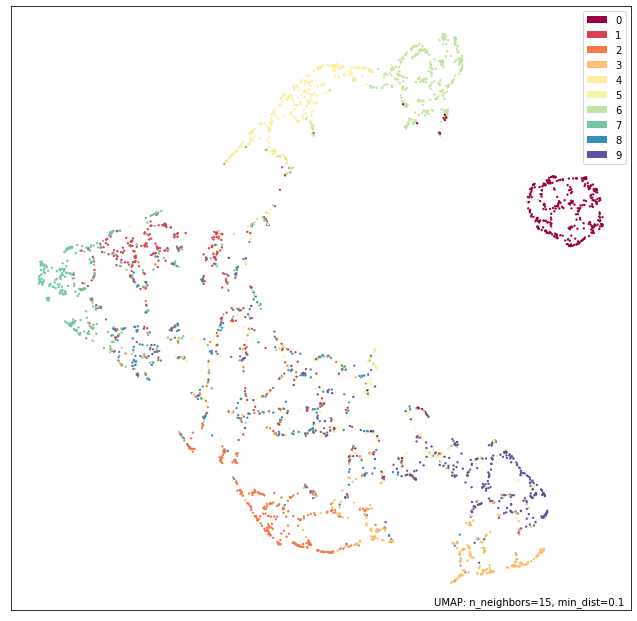

In [16]:
umap.plot.points(mapper, labels=y)